<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Explainable-Ai-for-The-ML-Models/blob/main/GAT_Grad_XAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Install required libraries (if not already installed)
!pip install torch torchvision torchaudio torch-geometric captum networkx opencv-python matplotlib


In [39]:
import torch
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from scipy.spatial import Delaunay
from captum.attr import IntegratedGradients
import torch_geometric

In [40]:
# prompt: code for mounting drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Load trained GAT model class and state_dict
class GATClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, heads=2):
        super(GATClassifier, self).__init__()
        self.conv1 = torch_geometric.nn.GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = torch_geometric.nn.GATConv(hidden_dim * heads, hidden_dim, heads=1)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.functional.relu(self.conv1(x, edge_index))
        x = torch.nn.functional.relu(self.conv2(x, edge_index))
        x = torch_geometric.nn.global_mean_pool(x, data.batch)
        x = self.fc(x)
        return torch.nn.functional.log_softmax(x, dim=1)


In [42]:
# Function to compute graph from image using ORB + Delaunay
def computeORBGraph(image):
    orb = cv2.ORB_create(nfeatures=700, scaleFactor=1.2, nlevels=8, edgeThreshold=15)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if not keypoints or descriptors is None:
        return None, None, None
    points = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    G = nx.Graph()
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y), descriptor=descriptors[i])
    if len(points) > 2:
        tri = Delaunay(points)
        for simplex in tri.simplices:
            for i in range(3):
                G.add_edge(simplex[i], simplex[(i+1) % 3])
    return G, keypoints, descriptors


In [43]:
# Load model
model = GATClassifier(input_dim=32).to('cpu')  # input_dim = ORB descriptor dim
model.load_state_dict(torch.load('/content/drive/MyDrive/gat_model.pth', map_location=torch.device('cpu')))
model.eval()


GATClassifier(
  (conv1): GATConv(32, 64, heads=2)
  (conv2): GATConv(128, 64, heads=1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [52]:
# Load and process a sample image
image_path = '/content/drive/MyDrive/Dataset4/Training/Real/2000_s2.jpg'  # Change for desired image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
G, keypoints, descriptors = computeORBGraph(image)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
x = torch.tensor(np.array([G.nodes[i]['descriptor'] for i in G.nodes]), dtype=torch.float)
data = Data(x=x, edge_index=edge_index, batch=torch.zeros(x.shape[0], dtype=torch.long))


In [53]:
def grad_cam_visualization(model, data, keypoints, image):
    data.x.requires_grad = True
    output = model(data)
    pred_class = output.argmax().item()
    output[0, pred_class].backward()

    gradients = data.x.grad
    cam = gradients.abs().sum(dim=1).detach().numpy()

    # Normalize CAM - Replace cam.ptp() with np.ptp(cam)
    cam = (cam - cam.min()) / (np.ptp(cam) + 1e-6)

    # Plot Grad-CAM heatmap on image
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i, kp in enumerate(keypoints):
        color = (0, int(255 * cam[i]), int(255 * (1 - cam[i])))
        cv2.circle(img_color, (int(kp.pt[0]), int(kp.pt[1])), 4, color, -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_color[:, :, ::-1])
    plt.title("Keypoints with Grad-CAM")
    plt.axis("off")
    plt.show()

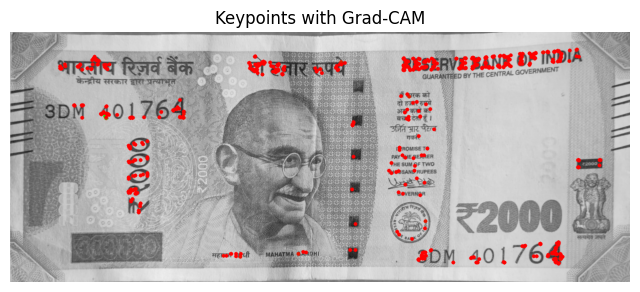

In [54]:
# Visualize Grad-CAM
grad_cam_visualization(model, data, keypoints, image)
